In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
# !pip install yahoo_fin --upgrade
import yahoo_fin
import numpy as np
from yahoo_fin.stock_info import get_data
import yfinance as yf

import math, time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl
np.random.seed(42)
torch.manual_seed(42)

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [3]:
def load_data(stock, look_back):
    close_idx = stock.columns.get_loc('close')
    data_raw = stock.values
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)

    test_size = int(0.2 * len(data))
    x_train = data[:-test_size, :-1, :].transpose(0,2,1)
    y_train = data[:-test_size, -1, close_idx]

    x_test = data[-test_size:, :-1].transpose(0,2,1)
    y_test = data[-test_size:, -1, close_idx]

    x_train = np.array(x_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    x_test = np.array(x_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)

    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)

    return [x_train, y_train, x_test, y_test]



In [4]:
class RNN(nn.Module):
    def __init__(self, nn_type, input_dim, hidden_dim, num_layers, output_dim,
                 cnn_channel=0, cnn_kernel_size=0, dropout=0, bidirectional=False):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.nn_type = nn_type
        self.cnn_channel = cnn_channel
        if self.cnn_channel > 0:
            self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=self.cnn_channel,
                                 kernel_size=cnn_kernel_size, stride=1)
        self.rnn = getattr(nn, nn_type)(cnn_channel if self.cnn_channel > 0 else input_dim,
                                        hidden_dim, num_layers, batch_first=True,
                                        bidirectional=bidirectional, dropout=dropout)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_dim * num_layers * (2 if bidirectional else 1), output_dim)

    def forward(self, x):
        if self.cnn_channel > 0:
            x = self.cnn(x.swapaxes(1, 2)).swapaxes(1, 2)
        if self.nn_type == 'LSTM':
            out, (hidden, cell) = self.rnn(x)
        else:
            out, hidden = self.rnn(x)
        return self.dropout(self.fc(self.flatten(hidden.swapaxes(0, 1))))

In [5]:
# Define TCN architecture
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size  # Change output size to 1
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.dropout = dropout

        # Define TCN layers
        self.tcn = nn.Sequential(
            nn.Conv1d(input_size, num_channels, kernel_size, padding=(kernel_size - 1) // 2),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size, dilation=2, padding=(kernel_size - 1)),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(num_channels, num_channels, kernel_size, dilation=4, padding=(kernel_size - 1)),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(num_channels, output_size, kernel_size=1),  # Adjust output_size to 1
            nn.Flatten()
        )


    def forward(self, x):
        # Expected input shape: (batch_size, num_channels, sequence_length)
        x = self.tcn(x)
        # Adjust the output shape to match [batch_size, output_size]
        #x = torch.mean(x, dim=2, keepdim=False)  # Take the mean across the sequence length dimension
        return x


In [6]:
def fetch_data_and_engineer_features(stock_ticker):
    stock = yf.Ticker(stock_ticker)
    industry = stock.info['industry']
    sector = stock.info['sector']
    # print(f"Ticker Symbol: {stock_ticker}")
    # print(f"Industry: {industry}")
    # print(f"Sector: {sector}")

    # Fetch data
    stock_data = get_data(stock_ticker, start_date="01/01/2010", end_date="12/31/2019", index_as_date=True, interval="1d")
#log returns
    stock_data['Log_Return'] = np.log(stock_data['close'] / stock_data['close'].shift(1))

    # 20 and 50 day moving day averages
    stock_data['SMA_20'] = stock_data['close'].rolling(window=20).mean()
    stock_data['SMA_50'] = stock_data['close'].rolling(window=50).mean()

    #exponential moving average/EMA
    stock_data['EMA_20'] = stock_data['close'].ewm(span=20, adjust=False).mean()

    #relative strength index/RSI
    window_length = 14
    delta = stock_data['close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_length - 1, adjust=True, min_periods=window_length).mean()
    ema_down = down.ewm(com=window_length - 1, adjust=True, min_periods=window_length).mean()
    rs = ema_up / ema_down
    stock_data['RSI'] = 100 - (100 / (1 + rs))

    #technical indicators
    stock_data['MACD'] = stock_data['close'].ewm(span=12).mean() - stock_data['close'].ewm(span=26).mean()
    stock_data['MACD_Signal'] = stock_data['MACD'].ewm(span=9).mean()
    stock_data['Stochastic_%K'] = stock_data['close'].rolling(window=14).apply(lambda x: (x[-1] - x.min()) / (x.max() - x.min()), raw=True)
    stock_data['Stochastic_%D'] = stock_data['Stochastic_%K'].rolling(window=3).mean()

    #volume indicators
    stock_data['Volume_SMA_20'] = stock_data['volume'].rolling(window=20).mean()
    stock_data['Volume_Ratio'] = stock_data['volume'] / stock_data['Volume_SMA_20']

    #volatility indicators
    stock_data['Daily_Return_Volatility'] = stock_data['Log_Return'].rolling(window=14).std() * np.sqrt(252)
    stock_data['Garman_Klass_Volatility'] = np.sqrt(252 * 0.5 * ((np.log(stock_data['close'] / stock_data['close'].shift(1)))**2).rolling(window=14).mean())

    #momentum and trend indicators
    stock_data['Price_Momentum'] = stock_data['close'].pct_change(periods=14)
    stock_data['Rate_of_Change'] = stock_data['close'].pct_change(periods=9)
    stock_data['Trend'] = np.where(stock_data['close'] > stock_data['close'].shift(1), 1, -1)

    stock_data['Day_of_Week'] = stock_data.index.dayofweek
    stock_data['Month'] = stock_data.index.month

    # information ratio
    stock_data['info_ratio'] = stock_data['close'] / stock_data['close'].shift(14) / stock_data['Daily_Return_Volatility']

    stock_data['close_change'] = stock_data['close'] - stock_data['close'].shift(1)
    stock_data['range'] = stock_data['high'] - stock_data['low']
    stock_data['ATR'] = stock_data['range'].rolling(window=14).mean()
    stock_data['stoc_oscillator'] = (stock_data['close'] - stock_data['low'].rolling(window=14).min()) / (stock_data['high'].rolling(window=14).max() - stock_data['low'].rolling(window=14).min())

    stock_data['cum_ret'] = stock_data['close'] / stock_data.iloc[-1]['open']

    stock_data = stock_data.sort_index(ascending=False).dropna().iloc[::-1]
    # Cell with the first scaling, normalize to -1 and 1 - method used in LSTM
    return stock_data


In [7]:
input_dim = 30
hidden_dim = 64
num_layers = 30
cnn_channel = 30 // 3
cnn_kernel_size = 5 #fixt his
output_dim = 1
dropout = 0.1 # 0.05
num_epochs = 33 # 40
lr=5e-4 #5e-4
device = 'cuda'

In [8]:

def train(model, device, train_loader, optimizer, epoch, loss_function):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze(1)
        target = target.unsqueeze(1)
        loss = loss_function(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        # if (batch_idx + 1) % (len(train_loader) // 4) == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)], Batch Loss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()
        #     ))
    return train_loss / len(train_loader)

In [9]:
def test(model, device, test_loader, epoch, loss_function):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #output = output.squeeze(dim=1)  # Remove the singleton dimension
            #target = target.unsqueeze(dim=1)  # Add a singleton dimension along the second dimension
            test_loss += loss_function(output.squeeze(), target.unsqueeze(dim=1)).item()

            #test_loss += loss_function(output, target).item()
    # print('Test epoch: {}, Test batch loss: {:.4f}'.format(
    #     epoch, test_loss / len(test_loader)
    # ))
    return test_loss / len(test_loader)

In [10]:
s_p = pd.read_csv(r'./constituents.csv')
full_ticker = s_p['Symbol'].tolist()
print(full_ticker)
exclude_list = ["ABNB", "BRK.B", "BF.B", "CARR", "CEG", "GEHC", "GEV", "KVUE", "OTIS", "SOLV", "VLTO"]
filtered_ticker = [ticker for ticker in full_ticker if ticker not in exclude_list]
test_tickers = filtered_ticker
# test_tickers = filtered_ticker[:30]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [11]:
train_rmse_list = []
test_rmse_list = []
start_time = time.time()

for stock_ticker in test_tickers:
    stock_data = fetch_data_and_engineer_features(stock_ticker)
    stock_data = stock_data.drop(columns=['ticker'])
    scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
    stock_data_temp = scaler.fit_transform(stock_data)
    scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
    scaler.fit(stock_data[['close']])
    stock_data = stock_data_temp


    # Load data
    x_train, y_train, x_test, y_test = load_data(stock_data, 61)

    # Create data loaders
    batch_size = 16
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=True)

    # Define TCN model
    model = TCN(input_size=input_dim, output_size=output_dim, num_channels=num_layers,
                kernel_size=cnn_kernel_size, dropout=dropout).to(device)

    # Define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Print model architecture
    #print(model)
    #print(len(list(model.parameters())))
    #for i in range(len(list(model.parameters()))):
    #    print(list(model.parameters())[i].size())

    # Lists to store training and validation losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(1, num_epochs + 1):
        # Train the model and compute training loss
        train_losses.append(train(model, device, train_loader, optimizer, epoch, loss_fn))
        # Validate the model and compute validation loss
        val_losses.append(test(model, device, test_loader, epoch, loss_fn))
        # Save the model if validation loss is minimum
        if val_losses[-1] == min(val_losses):
            torch.save(model.state_dict(), f'model_weights_TCN.pth')

    # Calculate train and test RMSE
    model.load_state_dict(torch.load('model_weights_TCN.pth'))
    #plt.plot(np.arange(1, num_epochs + 1), train_losses, label='train')
    #plt.plot(np.arange(1, num_epochs + 1), val_losses, label='val')
    #plt.legend()
    y_train_pred = model(x_train.to(device)).to('cpu')
    #y_train_pred
    #print(np.shape(y_train_pred))
    y_test_pred = model(x_test.to(device)).to('cpu')
    y_train_tensor = torch.tensor(y_train)
    y_test_tensor = torch.tensor(y_test)
    # print(np.shape(y_train))
    # print(np.shape(y_train_pred))
    # print(np.shape(y_test))
    # print(np.shape(y_test_pred))
    #scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
    #scaler.fit(stock_data[['close']])

    # Now you can use detach() on the PyTorch tensor
    y_train_pred = torch.mean(y_train_pred, dim=-1, keepdim=True).squeeze(dim=-1)
    # Inverse transform the predictions using the same scaler
    y_train_pred_numpy = scaler.inverse_transform(y_train_pred.detach().numpy().reshape(-1, 1))

    # Inverse transform the target values for training data
    y_train = scaler.inverse_transform(y_train_tensor.numpy().reshape(-1, 1))[:, 0]

    # Similar steps for test data
    y_test_pred = torch.mean(y_test_pred, dim=-1, keepdim=True).squeeze(dim=-1)
    y_test_pred_numpy = scaler.inverse_transform(y_test_pred.detach().numpy().reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))[:, 0]


    y_train_pred_orig = scaler.inverse_transform(y_train_pred.detach().numpy().reshape(-1, 1))
    y_train_orig = scaler.inverse_transform(y_train_tensor.numpy().reshape(-1, 1))[:, 0]

    y_test_pred_orig = scaler.inverse_transform(y_test_pred.detach().numpy().reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))[:, 0]

    # Calculate RMSE
    trainScore = math.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
    testScore = math.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))
    #y_test_pred_numpy = (y_test_pred.detach().numpy())
    #y_test = (y_test_tensor.numpy().reshape(-1, 1))[:, 0]

    # print(np.shape(y_train))
    # print(np.shape(y_train_pred_numpy))
    # print(np.shape(y_test))
    # print(np.shape(y_test_pred_numpy))

        # Calculate RMSE
    trainScore = math.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
    # print('Train Score: %.2f RMSE' % trainScore)
    train_rmse_list.append(trainScore)
    testScore = math.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig ))
    # print('Test Score: %.2f RMSE' % testScore)
    test_rmse_list.append(testScore)
    # plt.figure(figsize=(12, 6))
    # plt.plot(stock_data[len(stock_data)-len(y_test_orig):].index, y_test_orig, color='red', label='Real')
    # plt.plot(stock_data[len(stock_data)-len(y_test_orig):].index, y_test_pred_orig, color='blue', label='Predicted')
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.title('Real vs Predicted Stock Prices')
    # plt.legend()
    # plt.show()

np.savetxt("TCN_train.csv", train_rmse_list, delimiter=",")
np.savetxt("TCN_test.csv", test_rmse_list, delimiter=",")
# np.loadtxt("file", delimiter=",")
print(time.time() - start_time)

/homes/iws/zhaoyt/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/homes/iws/zhaoyt/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/homes/iws/zhaoyt/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have 

3890.230180978775


/tmp/ipykernel_530990/3565034351.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train)
/tmp/ipykernel_530990/3565034351.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test)


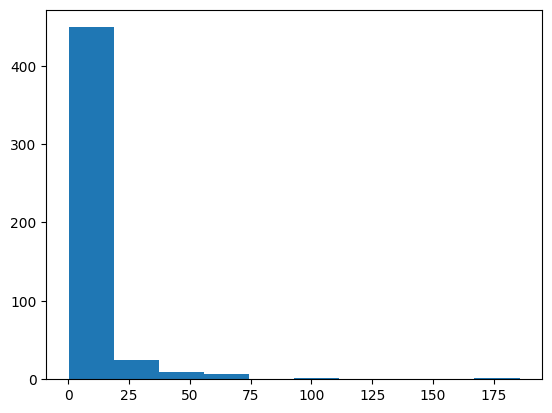

In [12]:
plt.hist(test_rmse_list)
plt.savefig("TCN.png")
plt.show()
# figure, axes = plt.subplots(figsize=(15, 6))
# axes.xaxis_date()
# axes.plot(stock_data[len(stock_data)-len(y_test):].index, y_test, color = 'red', label = 'real')
# axes.plot(stock_data[len(stock_data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'pred')
# plt.show()